# Demo

This notebook is a demonstration of how to use FRESCO to score molecules. It is recommended to run this notebook in a conda environment created from the `environment.yml` file in the root directory of the repo.

The runtime for this demo should only be a few minutes at max. The expected outputs of the cells are shown below.

# Fit a model on a fragment screen

## Loading fragment conformations

First of all, let's get the (aligned) conformations of fragments bound to the protein. These will likely be in separate files in your use case, and for convenience let's skip that data processing and just load a pre-prepared `.sdf` file with the conformations of 23 fragments bound to SARS-CoV-2 Mpro.

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

sdfFile = 'data/Mpro/mpro_frags.sdf'
df_fragments = PandasTools.LoadSDF(sdfFile, idName='name', smilesName='SMILES', molColName='mol')

INFO:rdkit:Enabling RDKit 2022.09.3 jupyter extensions


## Featurisation into pharmacophores

Next, we need to featurise the fragments into pharmacophores. This is done by calling a function from the `fresco` package.

This returns a dataframe containing the coordinate of each pharmacophore, the type of the pharmacophore, as well as thhe SMILES of the molecule that it comes from. The `weight` column accounts for any duplication of fragments in the fragment screen (not the case for Mpro but maybe happen in other cases).

In [2]:
from fresco.featurise import return_pcore_dataframe_for_list_of_mols

pcore_df = return_pcore_dataframe_for_list_of_mols(df_fragments['mol'].values)
pcore_df

100%|██████████| 23/23 [00:00<00:00, 94.93it/s]


,pcore,smiles,mol_id,coord_x,coord_y,coord_z,weight
0,Donor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,8.861200,5.12490,22.898400,1.0
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,13.086300,-1.09560,24.527300,1.0
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,13.990500,-0.35400,22.549900,1.0
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,11.183500,6.27380,23.371900,1.0
0,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,9.952600,5.45860,25.286300,1.0
...,...,...,...,...,...,...,...
0,Aromatic,CS(=O)(=O)NCCc1ccccc1,21,11.896383,-0.63445,23.420217,1.0
0,Donor,OC1CCN(Cc2ccsc2)CC1,22,9.278900,-4.20340,27.829500,1.0
0,Donor,OC1CCN(Cc2ccsc2)CC1,22,9.553400,-2.76170,24.573900,1.0
0,Acceptor,OC1CCN(Cc2ccsc2)CC1,22,9.278900,-4.20340,27.829500,1.0


## Calculate pharmacophore distance histograms

Next, we need to calculate the histogram of distances between pairs of pharmacophores. This is done by looping over a list of pharmacophore pairs and calling a function from the `fresco` package. We store the results in a dictionary.

We also have a dictionary of weights which again are to account for any duplication of fragments.

In [3]:
from fresco.featurise import return_default_pharmacophore_pairs, calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble

interesting_pcores = return_default_pharmacophore_pairs()
frag_pcore_histogram = {}
frag_pcore_weight = {}
for pcore_pair in interesting_pcores:
    core_a,core_b = pcore_pair.split('-')
    frag_pcore_histogram[pcore_pair], frag_pcore_weight[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble(pcore_df, core_a, core_b)

## Fit FRESCO model

Now, lets use unsupervised learning to model the distribution of pairwise pharmacophore distances. This returns a dictionary where each pharmacophore pair has a corresponding function that can be used to calculate the probability of a given distance between the two pharmacophores.

In [4]:
from fresco.model import fit_fresco_on_pcore_histograms,save_kde_model

frag_pcore_weight = {k: None for k, v in frag_pcore_histogram.items()}
kde = fit_fresco_on_pcore_histograms(
    frag_pcore_histogram, interesting_pcores, frag_pcore_weight)


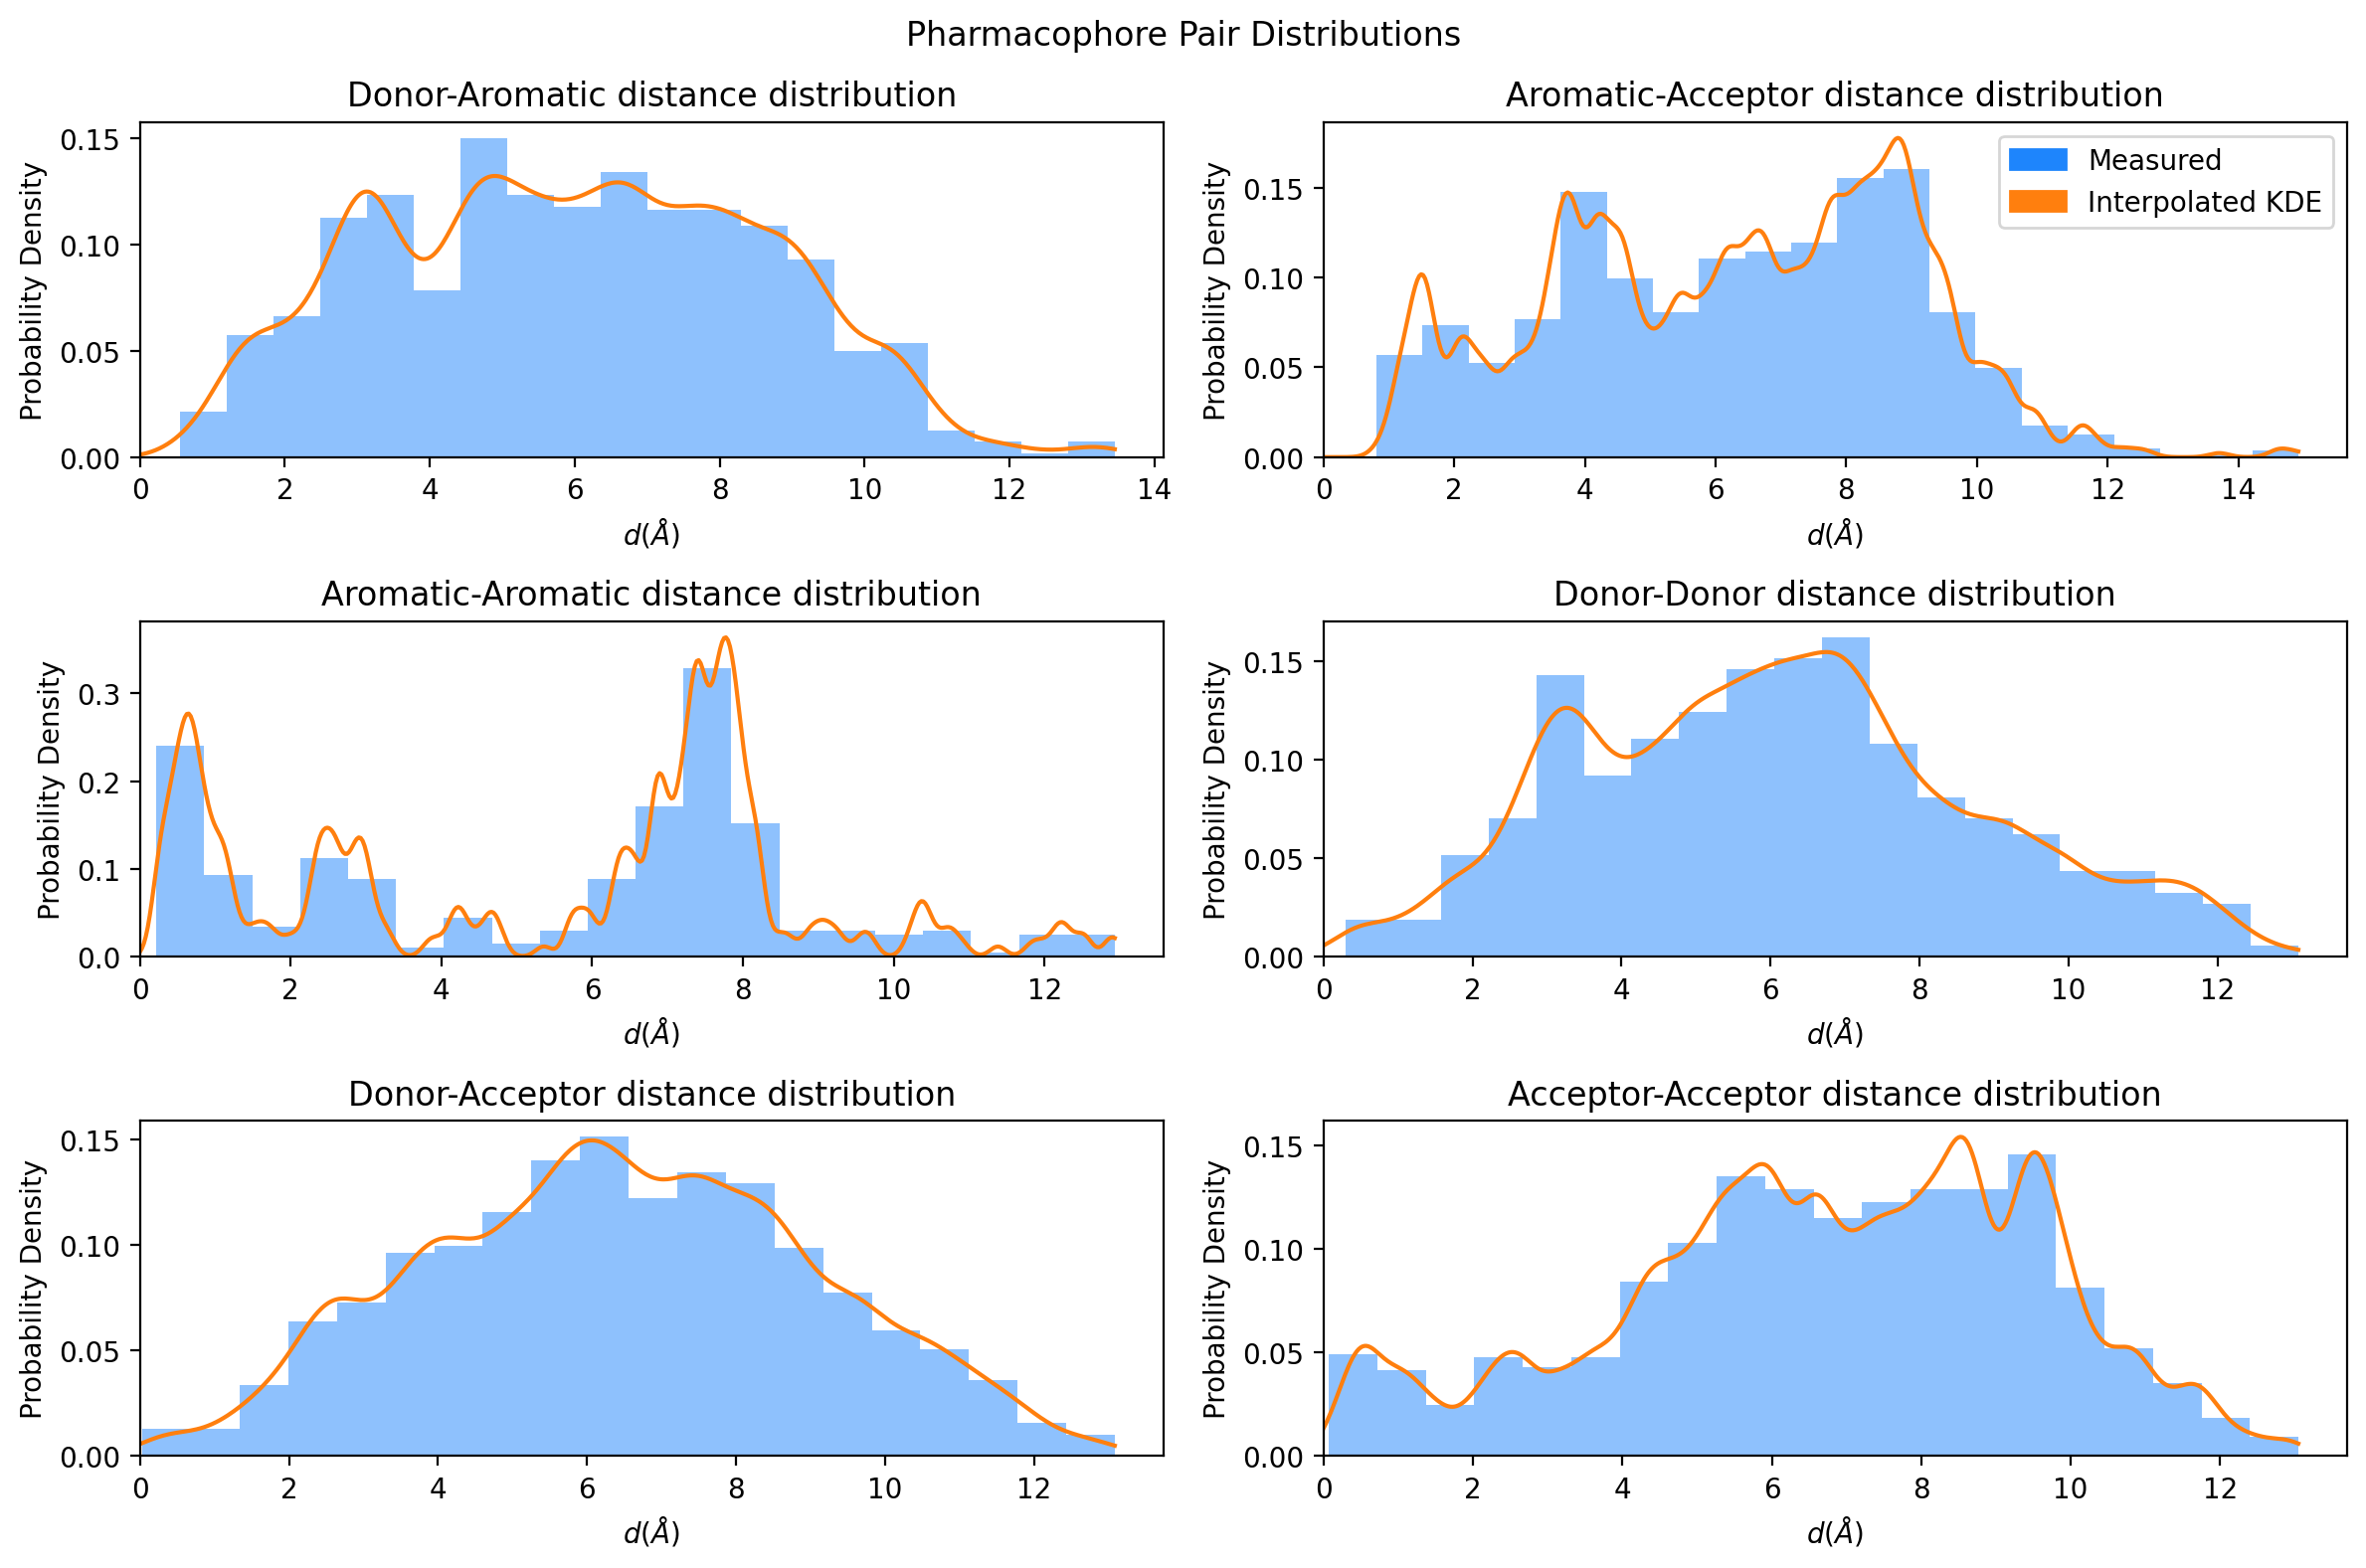

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

CMAP = plt.get_cmap("tab10")

def plot_kdes(kde_dicts, frag_2body_dict, interesting_pcores, nx=500, n_bins=20, title=''):

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,8), dpi=200)
    fig.suptitle(title)

    axs = axs.reshape(-1)
    for i, pcore_combo in enumerate(interesting_pcores):
        x = np.linspace(0, np.amax(frag_2body_dict[pcore_combo]), nx)
        kde_pair = kde_dicts[pcore_combo]
        axs[i].set_title('{} distance distribution'.format(
            pcore_combo))
        axs[i].hist(frag_2body_dict[pcore_combo], bins=n_bins,
                    alpha=0.5, density=True, color='#1E85FC')
        axs[i].plot(x, np.exp(kde_pair(x)), color=CMAP(1))
        axs[i].set_xlim(left=0)
        axs[i].set_ylabel('Probability Density')
        axs[i].set_xlabel(r'$d (\AA)$')
    legend_elements = [Rectangle((0, 0), 1, 1, color='#1E85FC', label='Measured'),
                    Rectangle((0, 0), 1, 1,  color=CMAP(1), label='Interpolated KDE')]
    axs[1].legend(handles=legend_elements, loc='upper right')
    fig.tight_layout()    
    return fig

fig_distributions = plot_kdes(
    kde, frag_pcore_histogram, interesting_pcores, title='Pharmacophore Pair Distributions')

# Use FRESCO to score a molecule

Now that we have a fitted FRESCO model, we can use it to score an unseen molecule!

## Get molecule conformation

First, we need the conformation of a molecule. Let's pick a random molecule and get a cheap conformation from RDKit.

In [6]:
from fresco.featurise import return_pcore_dataframe_from_single_rdkit_molecule
from rdkit.Chem import AllChem

smiles = 'Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)

0

## Generate pharmacophore 2-body distribution

As with the fragment screen, we need to generate the 2-body distribution (distance histogram) of pharmacophores.

In [7]:
from fresco.featurise import return_default_pharmacophore_pairs, calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand

mol_pcore_df = return_pcore_dataframe_from_single_rdkit_molecule(mol)

pcore_pairs = return_default_pharmacophore_pairs()

pair_distribution_for_this_ligand = {}
    
for pcore_pair in pcore_pairs:
    core_a,core_b = pcore_pair.split('-')
    pair_distribution_for_this_ligand[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(
        mol_pcore_df, core_a, core_b)

## Score molecule

Now let's score the molecule with the FRESCO model. This is done by looping over the pharmacophore pairs and calculating the probability of the distance between the two pharmacophores. We then take the mean of the log probabilities to get the score.

Score the molecule with the KDE!

In [8]:
from fresco.model import score_mol

score_for_this_mol = score_mol(kde, pair_distribution_for_this_ligand, pcore_pairs)
score_for_this_mol

-2.015132115570159

That's the gist of it - there are more functions in `fresco` related to filtering molecules by substructure and other things which are not covered here. Those functions are used in the screening workflow for screening EnamineREAL as described in the paper which are more directly tied to the hardware and data layout used internally and are hence not described here.